Let's try fitting frame(s) once we have a rough fit by minimizing the 3d-distance. 

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
from wcs_utils import apply_wcs_to_photometry, match_catalog, radec2altaz, trim_stars, robustRMS
from astropy.table import Table, vstack, hstack
import numpy as np

from lsst.all_sky_phot.wcs import wcs_refine

from astropy.io import fits
import matplotlib.pylab as plt
from astropy.io import fits
from astropy import wcs
from astropy.coordinates import SkyCoord
from read_ybc import readYBC
import astropy.units as u
import lsst.all_sky_phot.wcs as asp

from scipy.optimize import minimize

In [2]:
# Let's load up the WCS from the identified stars
hdulist = fits.open('wcs_asp_only.fits')
w = wcs.WCS(hdulist[0].header)
hdulist.close()

In [3]:
# Load the photometry of an entire night
temp = np.load('full_night.npz')
phot_tables = temp['phot_tables'][()]
temp.close()

# Let's try to fit one
i=30
phot_table = phot_tables[i]

alt_limit = 15.

# Let's clean out any things that are way off
az, alt = w.all_pix2world(phot_table['xcenter'], phot_table['ycenter'], 0)
good = np.where((alt > alt_limit) & (phot_table['residual_aperture_sum'].data > 0.))
phot_table = phot_table[good]

zp = -18

In [4]:
# Load the Yale bright star catalog
ybc = readYBC()
ybc_bright = np.where(ybc['Vmag'].values < 6)
#ybc_cat = SkyCoord(ra=ybc['RA'].values[ybc_bright]*u.degree, dec=ybc['Dec'].values[ybc_bright]*u.degree)

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


In [5]:
mag = -2.5*np.log10(phot_table['residual_aperture_sum'].data)- zp
fun = wcs_refine(phot_table['xcenter'].value, phot_table['ycenter'].value, mag,
                 phot_table['mjd'][0], ybc['RA'].values[ybc_bright],
                 ybc['Dec'].values[ybc_bright], ybc['Vmag'].values[ybc_bright])

If you need enough precision such that this matters (~<10 arcsec), you can
use the latest IERS predictions by running:

    >>> from astropy.utils import iers
    >>> iers.IERS.iers_table = iers.IERS_A.open(iers.IERS_A_URL)

 [astropy.coordinates.builtin_frames.utils]
If you need enough precision such that this matters (~<10 arcsec), you can
use the latest IERS predictions by running:

    >>> from astropy.utils import iers
    >>> iers.IERS.iers_table = iers.IERS_A.open(iers.IERS_A_URL)

 [astropy.coordinates.builtin_frames.utils]


In [6]:
x0 = fun.wcs2x0(w)
# Let's only use stars that are starting out 2 degrees away from a potential match
indx, d2, d3 = fun.find_distances(x0)

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/astropy/coordinates/builtin_frames/cirs_observed_transforms.py:119: RuntimeWarning: invalid value encountered in arcsin
  distance = np.sin(delta + np.arcsin(r*sindoverd))/sindoverd


In [7]:
fit_result = minimize(fun, x0, method='Powell', options={'maxiter': 20})

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/yoachim/lsst/Darwin

In [17]:
print x0
print fit_result.x


[  2.87267194e+03   1.98194944e+03   1.23546388e+00   1.02932540e+00
   2.91681385e-02   2.20383040e-03   2.77018818e-03  -3.50779379e-02
   2.59333243e+00  -1.99433904e+00]
[  2.87446357e+03   1.98190380e+03   1.23544134e+00   1.02956378e+00
   2.91759792e-02   2.18811211e-03   2.91599216e-03  -3.50866369e-02
   2.64486205e+00  -1.98879076e+00]


In [9]:
fun(x0)

7741.2057067219466

(array([  1.29500000e+03,   5.74000000e+02,   1.09000000e+02,
          3.50000000e+01,   1.40000000e+01,   6.00000000e+00,
          5.00000000e+00,   4.00000000e+00,   1.00000000e+00,
          3.00000000e+00]),
 array([  1.12855492e-02,   4.04205008e+00,   8.07281461e+00,
          1.21035791e+01,   1.61343437e+01,   2.01651082e+01,
          2.41958727e+01,   2.82266373e+01,   3.22574018e+01,
          3.62881663e+01,   4.03189309e+01]),
 <a list of 10 Patch objects>)

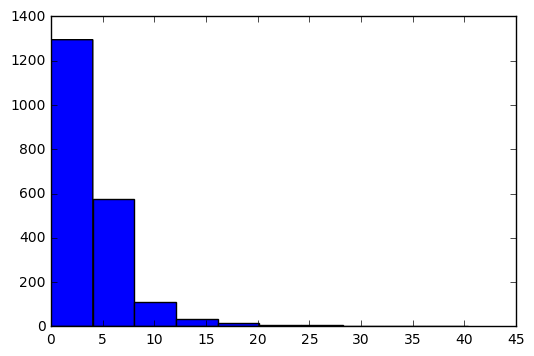

In [19]:
plt.hist(d2)

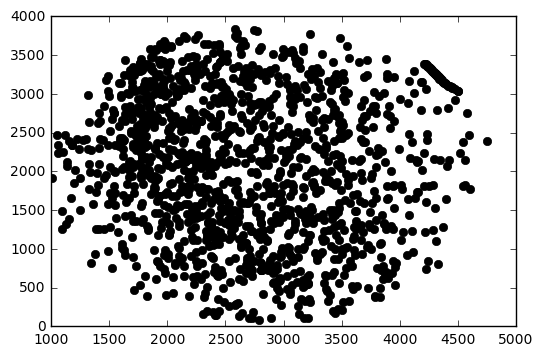

In [11]:
plt.plot(fun.x, fun.y, 'ko')

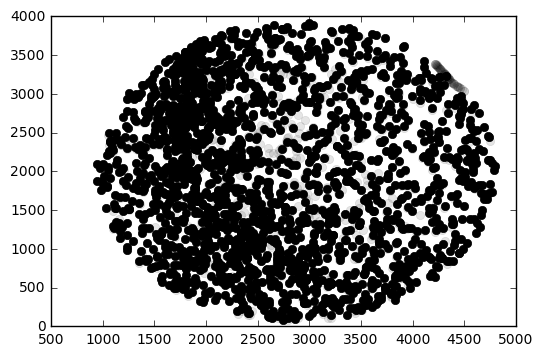

In [12]:
cat_x, cat_y = fun.w.all_world2pix(fun.ref_catalog.az, fun.ref_catalog.alt, 0)
plt.plot(cat_x, cat_y, 'ko')
plt.plot(fun.x, fun.y, 'ko', alpha=.1)

In [13]:
cat_x.size

2046

In [14]:
fun.x.size

1447